# Comparison of scenarios

In this notebook, we simulate the histopathology lab under a base scenario and a "lift-down"
scenario where the lift connecting the two floors of the lab is out of order. For further
analysis of the two scenarios, see the two `runner_times_` notebooks.

## Load configs

In [1]:
import openpyxl as oxl, pandas as pd, numpy as np

from histopath_bim_des.config import Config
from histopath_bim_des.model import Model

**Base config**

In [2]:
path = '../assets/config_base.xlsx'
wbook = oxl.load_workbook(path, data_only=True)
config = Config.from_workbook(wbook, sim_hours=10*168, num_reps=30, runner_speed=1.2)

**Lift down**

In [3]:
path2 = '../assets/config_lift_down.xlsx'
wbook2 = oxl.load_workbook(path2, data_only=True)
config2 = Config.from_workbook(wbook2, sim_hours=10*168, num_reps=30, runner_speed=1.2)

**Summary of runner times**

In [4]:
df = pd.DataFrame([{x[0]: x[1] for x in config.runner_times}, {x[0]: x[1] for x in config2.runner_times}]).T
df.columns = ['Base', 'LiftDown']
df

,Base,LiftDown
reception_cutup,8.452306,8.452306
cutup_processing,6.968697,6.968697
processing_microtomy,28.089256,28.089256
microtomy_staining,3.678511,3.678511
staining_labelling,3.678511,3.678511
labelling_scanning,86.898479,155.862945
scanning_qc,86.898479,155.862945
extra_loading,15.000000,15.000000
extra_unloading,15.000000,15.000000


## Simulation of Base config

In [5]:
lab_tats = []
specimen_datas = []

for _ in range(config.num_reps):
    model_base = Model(config)
    model_base.run()
    lab_tat_new = [v['qc_end']-v['reception_start']
                   for v in model_base.specimen_data.values() if 'qc_end' in v]
    specimen_datas.append(model_base.specimen_data)
    lab_tats.append(lab_tat_new)

In [6]:
lab_tat = np.concatenate(lab_tats)

In [7]:
lab_tat = lab_tat/24.
np.array([np.mean(lab_tat < n) for n in range(28)])

array([0.00000000e+00, 0.00000000e+00, 4.44205889e-04, 6.93278477e-03,
       4.11710113e-02, 6.84473682e-02, 1.07719928e-01, 2.66269702e-01,
       4.90474692e-01, 6.39463463e-01, 7.23891667e-01, 7.91011705e-01,
       8.50815567e-01, 8.96240908e-01, 9.35331026e-01, 9.62221347e-01,
       9.74624739e-01, 9.83014413e-01, 9.89547941e-01, 9.93902745e-01,
       9.97078289e-01, 9.99077215e-01, 9.99751456e-01, 9.99891593e-01,
       9.99941830e-01, 9.99978847e-01, 9.99994712e-01, 9.99997356e-01])

## Simulation of lift-down config

In [8]:
model_lift_down = Model(config2)

In [9]:
lab_tats2 = []
specimen_datas2 = []

for _ in range(config2.num_reps):
    model_lift_down = Model(config2)
    model_lift_down.run()
    lab_tat2_new = [v['qc_end']-v['reception_start']
                   for v in model_lift_down.specimen_data.values() if 'qc_end' in v]
    lab_tats2.append(lab_tat2_new)
    specimen_datas2.append(model_lift_down.specimen_data)


In [10]:
lab_tat2 = np.concatenate(lab_tats2)/24.
np.array([np.mean(lab_tat2 < n) for n in range(28)])

array([0.00000000e+00, 0.00000000e+00, 2.72461004e-04, 6.48729651e-03,
       3.48641101e-02, 5.90858933e-02, 9.52850623e-02, 2.16960698e-01,
       3.92847899e-01, 5.35906273e-01, 6.27646618e-01, 7.07237927e-01,
       7.74026292e-01, 8.30324910e-01, 8.82542061e-01, 9.27628908e-01,
       9.55237382e-01, 9.71991009e-01, 9.84450651e-01, 9.91123220e-01,
       9.95975751e-01, 9.98713984e-01, 9.99629453e-01, 9.99806553e-01,
       9.99871943e-01, 9.99926436e-01, 9.99961855e-01, 9.99994551e-01])

## Save data

In [26]:
import json

with open('outputs/config_compare_base.tats.json', 'w', encoding='utf-8') as file:
    json.dump(lab_tats, file)

with open('outputs/config_compare_lift_down.tats.json', 'w', encoding='utf-8') as file:
    json.dump(lab_tats2, file)

with open('outputs/config_compare_base.specimens.json', 'w', encoding='utf-8') as file:
    json.dump(specimen_datas, file)

with open('outputs/config_compare_lift_down.specimens.json', 'w', encoding='utf-8') as file:
    json.dump(specimen_datas2, file)

## Comparison

In [33]:
import numpy as np
import json
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt

# For skipping simulation
lab_tats = json.load(
    open('outputs/config_compare_base.tats.json', 'r', encoding='utf-8'))
lab_tats2 = json.load(
    open('outputs/config_compare_lift_down.tats.json', 'r', encoding='utf-8'))

lab_tat = np.concatenate(lab_tats)/24.
lab_tat2 = np.concatenate(lab_tats2)/24.

In [34]:
mat1 = np.array([[np.mean(np.array(lab_tats[i])/24. < n) for n in [7,10,14,21]] for i in range(30)])
mat2 = np.array([[np.mean(np.array(lab_tats2[i])/24. < n) for n in [7,10,14,21]] for i in range(30)])

In [35]:
mat1[:,0]

array([0.27767681, 0.31861004, 0.32030816, 0.17365079, 0.37452107,
       0.18592682, 0.24519193, 0.21921569, 0.30903316, 0.25232653,
       0.3133584 , 0.35086336, 0.20480936, 0.21739479, 0.45862828,
       0.23167435, 0.20903909, 0.30490272, 0.16639584, 0.38222706,
       0.29450363, 0.21780006, 0.24786325, 0.16263112, 0.17369405,
       0.30917345, 0.35299589, 0.34414331, 0.2057995 , 0.13292876])

**What is the proportion of specimens completed (reception to QC) within 7, 10, 14, or 21 days?**

In [36]:
# Base scenario

means1 = np.mean(mat1, axis=0)
means1

array([0.26524291, 0.72278014, 0.93498745, 0.99906045])

In [37]:
# Lift-down scenario

means2 = np.mean(mat2, axis=0)
means2

array([0.21616197, 0.62647169, 0.88206174, 0.99870332])

In [38]:
# Confidence interval half-width, base scenario

ci1 = [
    stats.t.interval(0.95, loc=np.mean(x:=mat1[:,col]), scale=stats.sem(x), df=len(x))
    for col in range(4)
]
yerr1 = np.array([v[1] for v in ci1])-means1
yerr1

array([0.02927592, 0.02518444, 0.00809137, 0.00042047])

In [39]:
# Confidence interval half-width, lift-down scenario

ci2 = [
    stats.t.interval(0.95, loc=np.mean(x:=mat2[:,col]), scale=stats.sem(x), df=len(x))
    for col in range(4)
]
yerr2 = np.array([v[1] for v in ci2])-means2
yerr2

array([0.02550822, 0.02835163, 0.01067065, 0.00056114])

**Plot the lab TAT distribution for the two scenarios:**

<Axes: xlabel='Elapsed time [days]', ylabel='Proportion of specimens completed'>

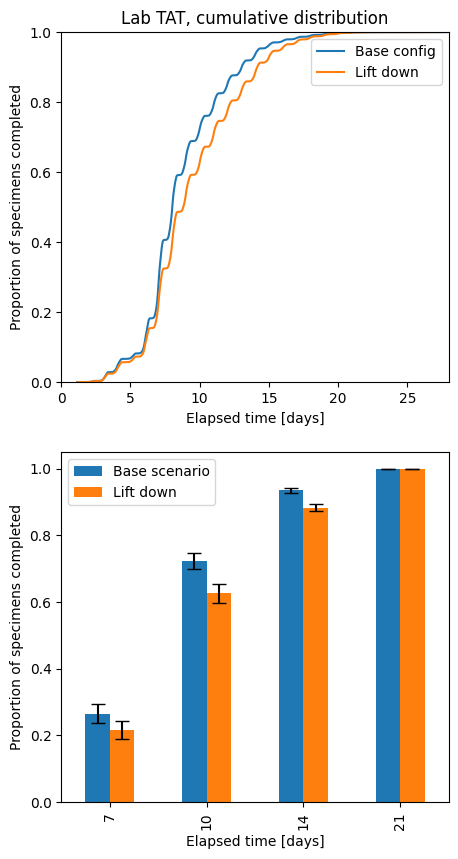

In [44]:
fig = plt.figure(figsize=(5,10))
ax1, ax2 = fig.subplots(2,1)

ax1.ecdf(lab_tat)
ax1.ecdf(lab_tat2)
ax1.legend(labels=['Base config', 'Lift down'])
ax1.set_xlabel('Elapsed time [days]')
ax1.set_title('Lab TAT, cumulative distribution')
ax1.set_ylabel('Proportion of specimens completed')
ax1.set_xlim(0,28)

y_df = pd.DataFrame(
    np.array([means1, means2]).T,
    index=[7,10,14,21],
    columns=['Base scenario', 'Lift down']
)
yerr_df = pd.DataFrame(
    np.array([yerr1, yerr2]).T,
    index=[7,10,14,21],
    columns=['Base scenario', 'Lift down']
)
y_df.plot(ax=ax2, kind='bar',yerr=yerr_df, capsize=5,
          xlabel='Elapsed time [days]', ylabel='Proportion of specimens completed')

**Mean lab TATs**

In [41]:
np.mean(lab_tat)

8.728869201205312

In [42]:
np.mean(lab_tat2)

9.456790067921988

**Compress files:**

```bash
tar -cvzf config_compare.tar.gz config_compare_*.json
tar -cvjf config_compare.tar.bz2 config_compare_*.json
```

In [43]:
from os import system
system("tar -cvjf outputs/config_compare.tar.bz2 outputs/config_compare_*.json")

outputs/config_compare_base.specimens.json
outputs/config_compare_base.tats.json
outputs/config_compare_lift_down.specimens.json
outputs/config_compare_lift_down.tats.json


0